In [ ]:
# Install Qiskit and Qiskit Aer
!pip install qiskit qiskit-aer

# Install yfinance if not already installed
!pip install yfinance

# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Verify installations
print("Imports successful!")

Imports successful!


Importing required libraries for analysis of FAANG companies (now MAANG)

In [ ]:
# Step 1: Get Real-Time Stock Data
tickers = ['AAPL', 'AMZN', 'GOOGL', 'NKE']  # Excluding 'FB'
data = yf.download(tickers, start="2023-01-01", end="2024-07-19")['Adj Close']
returns = data.pct_change().dropna() #we drop the NaN columns
# also we opt to annalyse simple returns instead of log returns for the sake of reducing complexity of the analysis
# one may opt to study log returns if more accuracy is demanded
cov_matrix = returns.cov()
corr_matrix = returns.corr()
expected_returns = returns.mean()
risk_free_rate = 0.03 #can be varried

[*********************100%%**********************]  4 of 4 completed


Text(0.5, 1.0, 'Covariance Matrix')

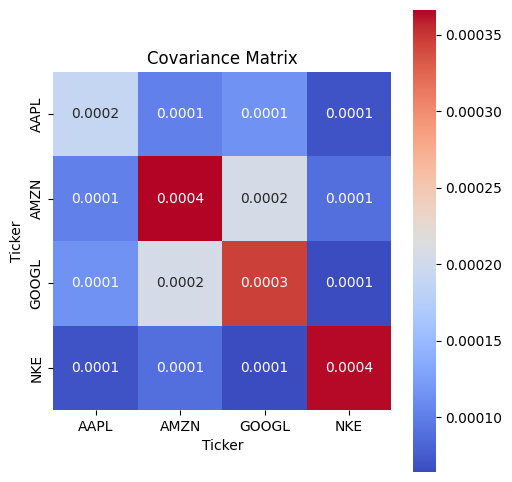

In [ ]:
# Visualize Covariance and Correlation Heatmaps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".4f", cbar=True, square=True, xticklabels=tickers, yticklabels=tickers)
plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Correlation Matrix')

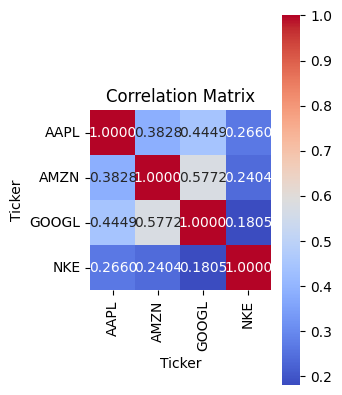

In [ ]:
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", cbar=True, square=True, xticklabels=tickers, yticklabels=tickers)
plt.title('Correlation Matrix')

Correlation, in the finance and investment industries, is a statistic that measures the degree to which two securities move in relation to each other the values are restricted to lie between -1 and +1.

A correlation of +1 means positive relation, i.e, if the correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases. A correlation of 0 means no relation.

covariance tells you that two variables change the same way while correlation reveals how a change in one variable affects a change in the other

In [ ]:
# Quantum Portfolio Optimization
def quantum_portfolio_optimization(mu, cov_matrix, risk_free_rate):
    num_assets = len(mu)

    # Define quantum circuit
    qc = QuantumCircuit(num_assets, num_assets)
    qc.h(range(num_assets))  # Apply Hadamard gate to all qubits
    qc.measure(range(num_assets), range(num_assets))  # Measure qubits

    # Define simulator backend
    backend = Aer.get_backend('qasm_simulator')
    # qasm_simulator - is a quantum simulator that emulates the behavior of a quantum computer on a classical computer.
    t_qc = transpile(qc, backend)
    # transpile is a function in Qiskit that takes a quantum circuit
    # and converts it into a form that is suitable for execution on a specific quantum device or simulator
    result = backend.run(t_qc, shots=1000).result()  # Directly pass the transpiled circuit
    #Shots means the number of times the quantum circuit is being exicuted

    # Process results and calculate portfolio composition
    counts = result.get_counts(qc)
    portfolio_composition = np.zeros(num_assets)
    # An array of zeros is initialized to store the composition of the portfolio.
    # This array will represent the proportion of each asset in the optimal portfolio.
    for state, count in counts.items():
        for i, bit in enumerate(state[::-1]):
            if bit == '1':
                portfolio_composition[i] += count

    portfolio_composition = portfolio_composition / sum(portfolio_composition) # so that sum adds up to 1
    portfolio_value = sum([(mu[i] - risk_free_rate) * portfolio_composition[i] for i in range(num_assets)]) #explained below

    return portfolio_composition, portfolio_value

Using the calculated portfolio composition, the expected return and risk-free rate, the value of the portfolio is computed. This is done by multiplying the excess return of each asset (compared to the risk-free rate) by its proportion in the portfolio, and then summing up these values.

In summary, this code block processes the results of the quantum simulation to determine the composition and value of the optimal portfolio based on the observed states and their frequencies.

In [ ]:
# Classical Portfolio Optimization
def classical_portfolio_optimization(mu, cov_matrix, risk_free_rate):
    num_assets = len(mu)
    # is calculated as the number of assets in the portfolio,
    # which is determined by the length of the expected returns vector (mu).
    ones = np.ones(num_assets)
    #An array ones is created with num_assets elements, all set to the value 1.This array will be used in subsequent calculations.
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    expected_return = mu - risk_free_rate * ones
    w = np.dot(inv_cov_matrix, expected_return) / np.dot(ones, np.dot(inv_cov_matrix, expected_return))
    portfolio_return = np.dot(w, mu)
    portfolio_std_dev = np.sqrt(np.dot(w, np.dot(cov_matrix, w)))

    return w, portfolio_return, portfolio_std_dev

The portfolio weights (w) are computed using linear algebra operations. It involves the dot product of the inverse covariance matrix and the expected returns, normalized by the dot product of the ones array and the result of another dot product operation.

The expected return of the portfolio is calculated as the dot product of the portfolio weights (w) and the expected returns of the assets (mu).

The standard deviation of the portfolio is calculated using linear algebra operations involving the covariance matrix (cov_matrix) and the portfolio weights (w).

The function returns the portfolio weights (w), expected return of the portfolio, and standard deviation of the portfolio.

In summary, it performs classical portfolio optimization by computing the optimal weights for assets in the portfolio, along with the expected return and standard deviation of the resulting portfolio.

In [ ]:
# Calculate time taken for classical optimization
start_time_classical = time.time() #current time
weights_classical, expected_return_classical, std_dev_classical = classical_portfolio_optimization(expected_returns, cov_matrix, risk_free_rate)
# the above line calls the function and passes the required parameters
end_time_classical = time.time() #records the end time
time_classical = end_time_classical - start_time_classical #difference b/w the two times is recorded

same procedure is done for the quantum portion

In [ ]:
# Calculate time taken for quantum optimization
start_time_quantum = time.time()
portfolio_composition_quantum, portfolio_value_quantum = quantum_portfolio_optimization(expected_returns, cov_matrix, risk_free_rate)
end_time_quantum = time.time()
time_quantum = end_time_quantum - start_time_quantum

In [ ]:
# Print classical optimization results
print(f'Classical Portfolio Optimization Results:')
print(f'Weights: {weights_classical}')
print(f'Expected Return: {expected_return_classical}')
print(f'Standard Deviation: {std_dev_classical}')


Classical Portfolio Optimization Results:
Weights: [0.50610829 0.09917646 0.12026473 0.27445051]
Expected Return: 0.0009892399933985098
Standard Deviation: 0.011909716904586334


In [ ]:
# Print quantum optimization results
print(f'Quantum Portfolio Optimization Results:')
print(f'Portfolio Composition: {portfolio_composition_quantum}')
print(f'Portfolio Value: {portfolio_value_quantum}')

Quantum Portfolio Optimization Results:
Portfolio Composition: [0.24343675 0.24677804 0.25441527 0.25536993]
Portfolio Value: -0.0288368824297787


([0, 1, 2, 3],
 [Text(0, 0, 'AAPL'),
  Text(1, 0, 'AMZN'),
  Text(2, 0, 'GOOGL'),
  Text(3, 0, 'NKE')])

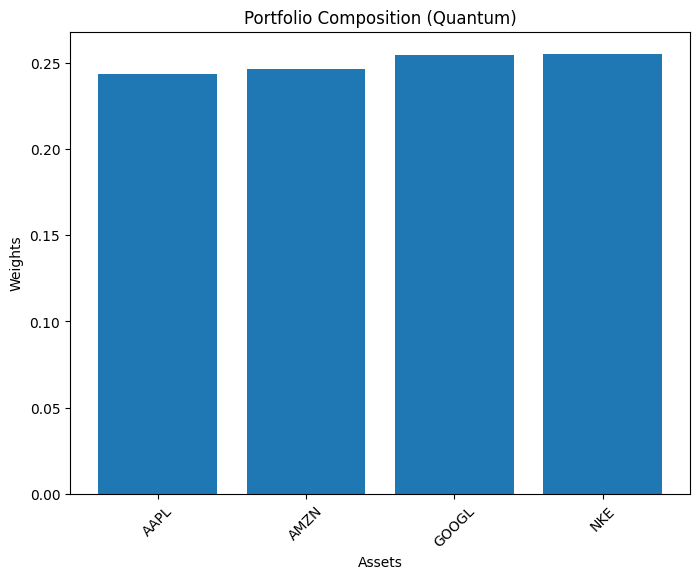

In [ ]:
# Visualize the portfolio composition (Quantum)
plt.figure(figsize=(8, 6))
plt.bar(expected_returns.index, portfolio_composition_quantum)
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Composition (Quantum)')
plt.xticks(rotation=45)

Summarising the results obtained from the quantum function, it gives the optimal composition the investor should opt for maximum returns and minimum risk

([0, 1, 2, 3],
 [Text(0, 0, 'AAPL'),
  Text(1, 0, 'AMZN'),
  Text(2, 0, 'GOOGL'),
  Text(3, 0, 'NKE')])

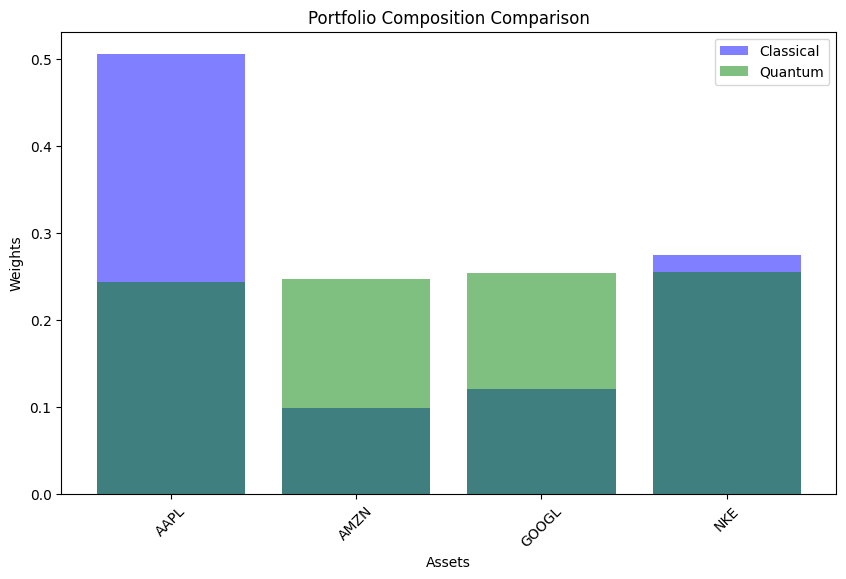

In [ ]:
# Compare classical and quantum portfolio compositions
plt.figure(figsize=(10, 6))
plt.bar(expected_returns.index, weights_classical, alpha=0.5, color='blue', label='Classical')
plt.bar(expected_returns.index, portfolio_composition_quantum, alpha=0.5, color='green', label='Quantum')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Composition Comparison')
plt.legend()
plt.xticks(rotation=45)

a bar graph to compare how the differences b/w the two approaches

Text(0.5, 1.0, 'Portfolio Optimization Performance Comparison')

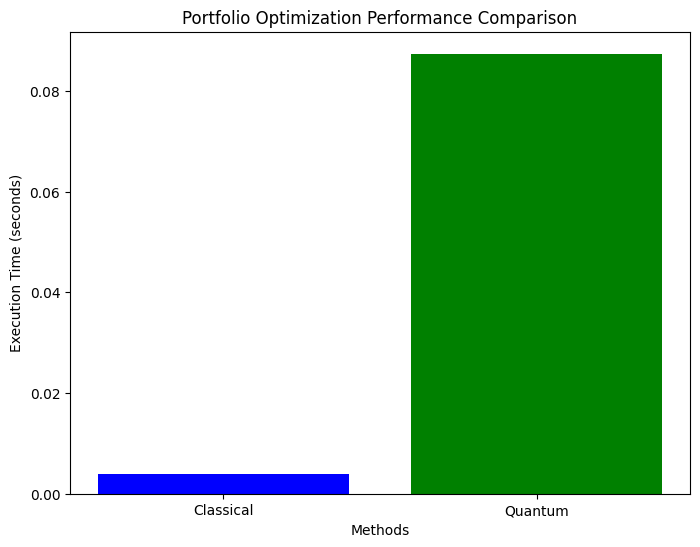

In [ ]:
# Compare performance
methods = ['Classical', 'Quantum']
times = [time_classical, time_quantum]
plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green'])
plt.xlabel('Methods')
plt.ylabel('Execution Time (seconds)')
plt.title('Portfolio Optimization Performance Comparison')

In this particular case the classical approach is out performing the quantum approach but, if we consider bigger portfolios and more complex relations then quantum would be out performing the classical analogy.

Also, Running a quantum simulation on a classical computer can sometimes be slower than performing the classical calculations directly, especially for small problem sizes.

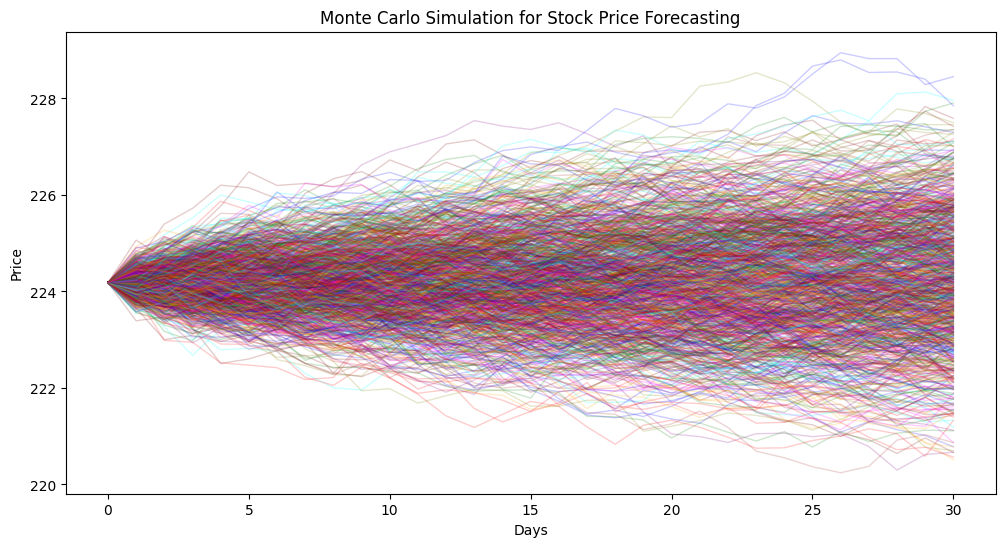

In [ ]:
# Function for Monte Carlo Simulation Forecasting
def monte_carlo_forecast(start_price, days, mean, std_dev):
    dt = 1/252  # Assuming trading days in a year
    num_simulations = 1000  # Number of simulations
    price_paths = np.zeros((num_simulations, days+1))

    for i in range(num_simulations):
        Z = np.random.normal(0, 1, days)
        daily_returns = np.exp((mean - (std_dev**2) / 2) * dt + std_dev * np.sqrt(dt) * Z)
        price_path = np.zeros(days+1)
        price_path[0] = start_price
        for t in range(1, days+1):
            price_path[t] = price_path[t-1] * daily_returns[t-1]
        price_paths[i, :] = price_path

    return price_paths

# Perform Monte Carlo Simulation for Forecasting
start_price = data.iloc[-1]['AAPL']  # Assuming 'AAPL' is the target stock
forecast_days = 30  # Forecast for the next 30 days
mean_daily_return = returns.mean().mean()
std_dev_daily_return = returns.std().mean()
monte_carlo_prices = monte_carlo_forecast(start_price, forecast_days, mean_daily_return, std_dev_daily_return)

# Generate a color palette for visualization
colors = ['red', 'green', 'maroon', 'blue', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'olive']

# Ploting the Monte Carlo Simulation used for Forecasting
plt.figure(figsize=(12, 6))
for i in range(monte_carlo_prices.shape[0]):
    plt.plot(range(forecast_days+1), monte_carlo_prices[i, :], color=colors[i % len(colors)], alpha=0.2, linewidth=1)

plt.title('Monte Carlo Simulation for Stock Price Forecasting')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


Here, I have done a monte carlo simulation using Geometric Bronian Motion(GBM), for simplicity one may use Arithematic Broninian Motion(ABM) too, it helps us for cast different paths the stock prices according to the number of simulations asked for and at the end of time frame (30 days in this case) we analyse all the distributions using a histogram (which hasn't been done due to the time constraint) which helps the investor analyse the forecast of the stock prices.

In summary, this function uses GBM to generate multiple possible future price paths for a given asset. The parameters mean and std_dev are based on historical returns data, and the simulation provides a range of potential future scenarios.